# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 21.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 14.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 33.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 538 kB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [9]:
client = MongoClient(mongod_connect)
db = client.gp18 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [10]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [11]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [12]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5246403,-77.5633015,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [13]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Thu Nov 19 18:25:20 +0000 2020'
'Thu Nov 19 18:25:03 +0000 2020'
'Thu Nov 19 18:25:02 +0000 2020'
'Thu Nov 19 18:24:49 +0000 2020'
'Thu Nov 19 18:24:37 +0000 2020'
'Thu Nov 19 18:24:36 +0000 2020'
'Thu Nov 19 18:24:25 +0000 2020'
'Thu Nov 19 18:24:19 +0000 2020'
'Thu Nov 19 18:24:11 +0000 2020'
'Thu Nov 19 18:23:55 +0000 2020'
'Thu Nov 19 18:23:43 +0000 2020'
'Thu Nov 19 18:23:41 +0000 2020'
'Thu Nov 19 18:23:36 +0000 2020'
'Thu Nov 19 18:23:35 +0000 2020'
'Thu Nov 19 18:23:30 +0000 2020'
'Thu Nov 19 18:23:29 +0000 2020'
'Thu Nov 19 18:23:27 +0000 2020'
'Thu Nov 19 18:23:27 +0000 2020'
'Thu Nov 19 18:23:23 +0000 2020'
'Thu Nov 19 18:23:06 +0000 2020'
'Thu Nov 19 18:23:00 +0000 2020'
'Thu Nov 19 18:22:50 +0000 2020'
'Thu Nov 19 18:22:43 +0000 2020'
'Thu Nov 19 18:22:42 +0000 2020'
'Thu Nov 19 18:22:41 +0000 2020'
'Thu Nov 19 18:22:40 +0000 2020'
'Thu Nov 19 18:22:36 +0000 2020'
'Thu Nov 19 18:22:35 +0000 2020'
'Thu Nov 19 18:22:31 +0000 2020'
'Thu Nov 19 18:22:22 +0000 2020'
'Thu Nov 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [16]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Thu Nov 19 17:02:14 +0000 2020'
'Thu Nov 19 17:02:06 +0000 2020'
'Thu Nov 19 17:01:59 +0000 2020'
'Thu Nov 19 17:01:57 +0000 2020'
'Thu Nov 19 17:01:56 +0000 2020'
'Thu Nov 19 17:01:48 +0000 2020'
'Thu Nov 19 17:01:29 +0000 2020'
'Thu Nov 19 17:01:28 +0000 2020'
'Thu Nov 19 17:01:23 +0000 2020'
'Thu Nov 19 17:01:21 +0000 2020'
'Thu Nov 19 17:01:21 +0000 2020'
'Thu Nov 19 17:01:21 +0000 2020'
'Thu Nov 19 17:01:16 +0000 2020'
'Thu Nov 19 17:01:14 +0000 2020'
'Thu Nov 19 17:01:08 +0000 2020'
'Thu Nov 19 17:01:03 +0000 2020'
'Thu Nov 19 17:01:03 +0000 2020'
'Thu Nov 19 17:00:59 +0000 2020'
'Thu Nov 19 17:00:36 +0000 2020'
'Thu Nov 19 17:00:25 +0000 2020'
'Thu Nov 19 17:00:22 +0000 2020'
'Thu Nov 19 17:00:19 +0000 2020'
'Thu Nov 19 17:00:18 +0000 2020'
'Thu Nov 19 17:00:17 +0000 2020'
'Thu Nov 19 17:00:15 +0000 2020'
'Thu Nov 19 17:00:13 +0000 2020'
'Thu Nov 19 17:00:09 +0000 2020'
'Thu Nov 19 17:00:03 +0000 2020'
'Thu Nov 19 17:00:03 +0000 2020'
'Thu Nov 19 17:00:02 +0000 2020'
'Thu Nov 1

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [17]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1769
1558


Create a text index and print the Tweets containing specific keywords. 

In [18]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [19]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [20]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Elizabeth ✨
text: #COVID19 #COVID19AB #Biden #trump #TransitionNow #GOPCorruptionOverCountry #ScienceMatters #science #TrumpCrimeFamily #COVIDー19
----
name: Karen R. Lips
text: RT @NASEM_BISO: Our #International Collaboration in the #COVID19 Era webinar will examine how COVID19 has disrupted formal mechanisms for k…
----
name: 📢 Karen Murphy ☘️
text: @Abraxsys Short memories.
#COVID19
----
name: It is time
text: look what you did @realdonaldTrump number dead under your watch952#COVID19
----
name: It is time
text: look what you did @realdonaldTrump number dead under your watch954#COVID19
----
name: It is time
text: look what you did @realdonaldTrump number dead under your watch958#COVID19
----
name: It is time
text: look what you did @realdonaldTrump number dead under your watch955#covid19
----
name: It is time
text: look what you did @realdonaldTrump number dead under your watch956#COVID19
----
name: It is time
text: look what you did @realdonaldTrump number dead under your 

In [21]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [22]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,possibly_sensitive,extended_entities
0,5fb6b8ee073bdf98a3f83a04,Thu Nov 19 17:39:04 +0000 2020,1329479317449895940,1329479317449895940,#COVID19 #COVID19AB #Biden #trump #TransitionN...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",1.329477e+18,...,1,False,False,und,NaN,NaN,NaN,NaN,NaN,NaN
1,5fb6b930073bdf98a3f83e53,Thu Nov 19 16:08:00 +0000 2020,1329456401924710401,1329456401924710401,RT @NASEM_BISO: Our #International Collaborati...,False,"{'hashtags': [{'text': 'International', 'indic...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,{'created_at': 'Wed Nov 18 02:03:41 +0000 2020...,NaN,NaN,NaN,NaN,NaN
2,5fb6b92b073bdf98a3f83c6b,Thu Nov 19 16:52:22 +0000 2020,1329467563542269954,1329467563542269954,@Abraxsys Short memories.\n#COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.329446e+18,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
3,5fb6b92e073bdf98a3f83dde,Thu Nov 19 16:16:00 +0000 2020,1329458412128595968,1329458412128595968,look what you did @realdonaldTrump number dead...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
4,5fb6b92e073bdf98a3f83dc7,Thu Nov 19 16:18:00 +0000 2020,1329458915449270273,1329458915449270273,look what you did @realdonaldTrump number dead...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
5,5fb6b92e073bdf98a3f83dbd,Thu Nov 19 16:19:00 +0000 2020,1329459167057170435,1329459167057170435,look what you did @realdonaldTrump number dead...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
6,5fb6b92e073bdf98a3f83dbc,Thu Nov 19 16:19:00 +0000 2020,1329459167296368642,1329459167296368642,look what you did @realdonaldTrump number dead...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
7,5fb6b92e073bdf98a3f83db1,Thu Nov 19 16:20:00 +0000 2020,1329459418786914304,1329459418786914304,look what you did @realdonaldTrump number dead...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
8,5fb6b92e073bdf98a3f83da0,Thu Nov 19 16:22:00 +0000 2020,1329459921990144002,1329459921990144002,look what you did @realdonaldTrump number dead...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
9,5fb6b92e073bdf98a3f83d9f,Thu Nov 19 16:22:00 +0000 2020,1329459922203930624,1329459922203930624,look what you did @realdonaldTrump number dead...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN


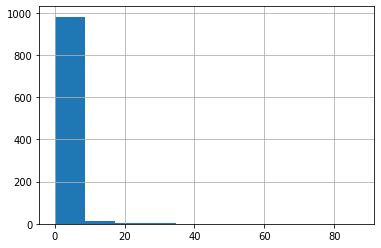

In [23]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count